# Trabalho 1 - Previsão de Série Temporal com Lógica Fuzzy

**Dataset**: Apple Stock (AAPL) - a1621595_data.csv

**Objetivo**: Implementar um Sistema de Inferência Fuzzy (SIF) usando o método de Wang & Mendel para prever valores futuros de uma série temporal.

## Requisitos do Enunciado:
1. Realizar previsão **um passo à frente** usando SIF
2. Fazer **passo a passo manual** da extração de regras para os 10 primeiros registros
3. Variar número de conjuntos fuzzy, tamanho de janela, operações de interseção, implicação e defuzzificação

=======================================================

Este notebook conterá os procedimentos para a questão 01 do trabalho. Para a questão 02 e outros detalhes adicionais, checar em "../../docs/TRABALHO-1_ELE2399-LF_Paloma.pdf"

In [1]:
import os
import sys
sys.path.append("..")

from pathlib import Path
import pandas as pd
from skfuzzy import control as ctrl
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as npa
import skfuzzy as fuzz
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from src.rule_generation import *
from src.fuzzy_utils import *

* Parâmetros para serem alterados para a busca do melhor desempenho

In [ ]:
# PARÂMETRO VARIÁVEIS
WINDOW_SIZE = 7
NUM_FUZZY_SETS = 5
METODO_DEFUZZIFICACAO = defuzzificacao_centroid
OPERACAO_INTERSECAO = operacao_intersecao_min
OPERACAO_IMPLICACAO = implicacao_prod


In [3]:
TS_DATA_FILENAME = 'a1621595_data.csv'
FILE_PATH = Path.cwd().parent / 'data' / TS_DATA_FILENAME

* carregamento dos dados.
* gerando o dataframe com base na função de criação de lags.

In [4]:
df = lags_create(WINDOW_SIZE, FILE_PATH, 'Close')

In [5]:
dic_operacoes_intersecao = {
    operacao_intersecao_min: "Mínimo",
    operacao_intersecao_prod: "Produto",
    operacao_intersecao_avg: "Média"
}

dic_implicacoes = {
    implicacao_min: "Mínimo",
    implicacao_maxmin: "Soma truncada",
    implicacao_prod: "Produto"
}

dic_defuzzificacao = {
    defuzzificacao_centroid: "Centro de Gravidade",
    defuzzificacao_mean_of_maxima: "Média dos Máximos",
    defuzzificacao_weighted_average: "Média Ponderada"
}

## Iniciando o sistema de inferência

* Definição dos Conjuntos Fuzzy.

    Criando variáveis linguísticas fuzzy para cada lag da série temporal.

    Nessa etapa, criamos e modificamos as variáveis linguísticas (e seus respectivos conjuntos Fuzzy) para chegar a uma melhor resposta. 

In [6]:
variable_list = create_fuzzy_variables(
    df, NUM_FUZZY_SETS, METODO_DEFUZZIFICACAO)

* Extração das Regras Fuzzy Usando o Método de Wang & Mendel

In [7]:
train_df = df.iloc[:int(len(df) * 0.9)]
test_df = df.iloc[int(len(df) * 0.9):]

fuzzy_system = create_fuzzy_system(
    train_df, variable_list, OPERACAO_INTERSECAO, OPERACAO_IMPLICACAO, 1)

* Construção do Sistema de Inferência Fuzzy (SIF)

In [8]:
fuzzy_sim = ctrl.ControlSystemSimulation(fuzzy_system)

* Previsão para o conjunto de treino e teste.
* Plotagem dos resultados.

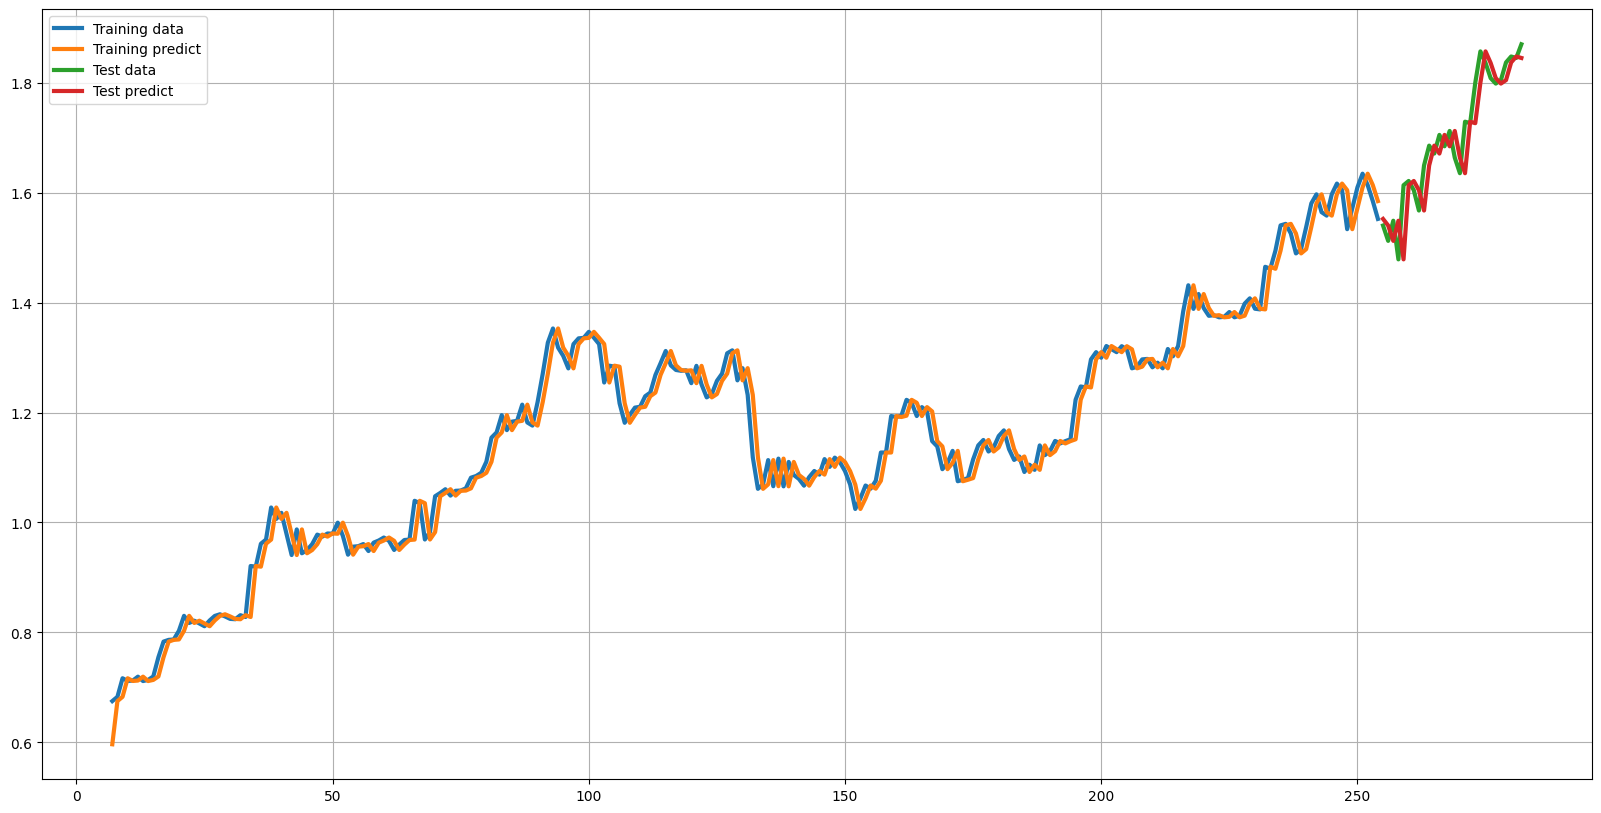

In [9]:
predict_train_df = predict(fuzzy_sim, train_df,METODO_DEFUZZIFICACAO)
    
predict_test_df = predict(fuzzy_sim, test_df, METODO_DEFUZZIFICACAO)


plt.figure(figsize=(20, 10))
plt.plot(predict_train_df['target'], label='Training data', linewidth=3)
plt.plot(predict_train_df['predict'], label='Training predict', linewidth=3)
plt.plot(predict_test_df['target'], label='Test data', linewidth=3)
plt.plot(predict_test_df['predict'], label='Test predict', linewidth=3)
plt.legend()
plt.grid()

plt.show()

* Avaliação de desempenho

In [10]:
mse_train, rmse_train, predict_train_df = avaliar_modelo(fuzzy_sim, train_df, METODO_DEFUZZIFICACAO)
mse_test, rmse_test, predict_test_df = avaliar_modelo(fuzzy_sim, test_df, METODO_DEFUZZIFICACAO)

print(f"{NUM_FUZZY_SETS} conjuntos fuzzy com janela de {WINDOW_SIZE} dias")
print(f"Método de defuzzificação: {dic_defuzzificacao[METODO_DEFUZZIFICACAO]}")
print(f"Operação de interseção: {dic_operacoes_intersecao[OPERACAO_INTERSECAO]}")
print(f"Implicação: {dic_implicacoes[OPERACAO_IMPLICACAO]}")
print(f"MSE Treino: {mse_train}")
print(f"RMSE Treino: {rmse_train}\n")
print(f"MSE Teste: {mse_test}")
print(f"RMSE Teste: {rmse_test}")

5 conjuntos fuzzy com janela de 7 dias
Método de defuzzificação: Centro de Gravidade
Operação de interseção: Mínimo
Implicação: Produto
MSE Treino: 0.0008383450693580858
RMSE Treino: 0.028954189150416313

MSE Teste: 0.0021921380173535866
RMSE Teste: 0.04682027357196439


#### Avaliação de desempenho e estatísticas adicionais dos resíduos

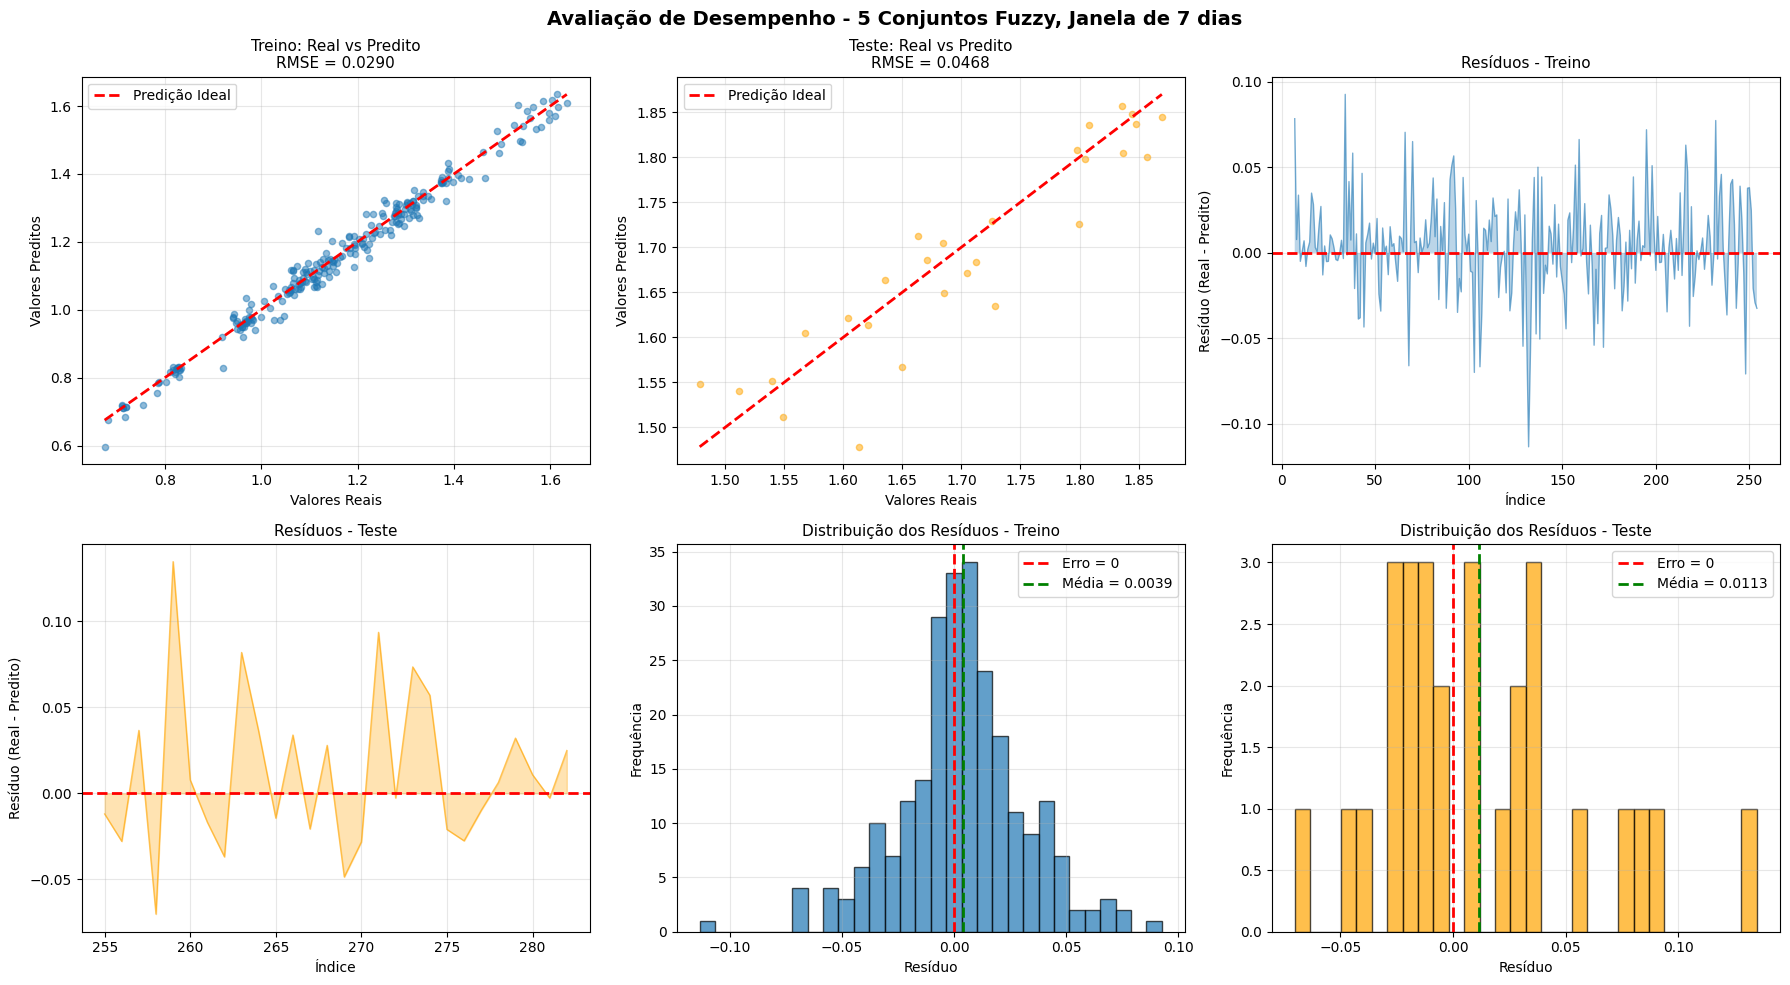


ESTATÍSTICAS DOS RESÍDUOS:

TREINO:
   Média dos Resíduos:      0.003852
   Desvio Padrão:           0.028755
   Resíduo Mínimo:          -0.113476
   Resíduo Máximo:          0.092762

TESTE:
   Média dos Resíduos:      0.011343
   Desvio Padrão:           0.046259
   Resíduo Mínimo:          -0.070247
   Resíduo Máximo:          0.134791


In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(f'Avaliação de Desempenho - {NUM_FUZZY_SETS} Conjuntos Fuzzy, Janela de {WINDOW_SIZE} dias', 
             fontsize=14, fontweight='bold')

ax = axes[0, 0]
ax.scatter(predict_train_df['target'], predict_train_df['predict'], alpha=0.5, s=20)
ax.plot([predict_train_df['target'].min(), predict_train_df['target'].max()], 
        [predict_train_df['target'].min(), predict_train_df['target'].max()], 
        'r--', linewidth=2, label='Predição Ideal')
ax.set_xlabel('Valores Reais', fontsize=10)
ax.set_ylabel('Valores Preditos', fontsize=10)
ax.set_title(f'Treino: Real vs Predito\nRMSE = {rmse_train:.4f}', fontsize=11)
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.scatter(predict_test_df['target'], predict_test_df['predict'], alpha=0.5, s=20, color='orange')
ax.plot([predict_test_df['target'].min(), predict_test_df['target'].max()], 
        [predict_test_df['target'].min(), predict_test_df['target'].max()], 
        'r--', linewidth=2, label='Predição Ideal')
ax.set_xlabel('Valores Reais', fontsize=10)
ax.set_ylabel('Valores Preditos', fontsize=10)
ax.set_title(f'Teste: Real vs Predito\nRMSE = {rmse_test:.4f}', fontsize=11)
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 2]
residuos_train = predict_train_df['target'] - predict_train_df['predict']
ax.plot(residuos_train.index, residuos_train, alpha=0.6, linewidth=1)
ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax.fill_between(residuos_train.index, residuos_train, 0, alpha=0.3)
ax.set_xlabel('Índice', fontsize=10)
ax.set_ylabel('Resíduo (Real - Predito)', fontsize=10)
ax.set_title('Resíduos - Treino', fontsize=11)
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
residuos_test = predict_test_df['target'] - predict_test_df['predict']
ax.plot(residuos_test.index, residuos_test, alpha=0.6, linewidth=1, color='orange')
ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax.fill_between(residuos_test.index, residuos_test, 0, alpha=0.3, color='orange')
ax.set_xlabel('Índice', fontsize=10)
ax.set_ylabel('Resíduo (Real - Predito)', fontsize=10)
ax.set_title('Resíduos - Teste', fontsize=11)
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.hist(residuos_train, bins=30, alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Erro = 0')
ax.axvline(x=residuos_train.mean(), color='g', linestyle='--', linewidth=2, 
           label=f'Média = {residuos_train.mean():.4f}')
ax.set_xlabel('Resíduo', fontsize=10)
ax.set_ylabel('Frequência', fontsize=10)
ax.set_title('Distribuição dos Resíduos - Treino', fontsize=11)
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 2]
ax.hist(residuos_test, bins=30, alpha=0.7, edgecolor='black', color='orange')
ax.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Erro = 0')
ax.axvline(x=residuos_test.mean(), color='g', linestyle='--', linewidth=2, 
           label=f'Média = {residuos_test.mean():.4f}')
ax.set_xlabel('Resíduo', fontsize=10)
ax.set_ylabel('Frequência', fontsize=10)
ax.set_title('Distribuição dos Resíduos - Teste', fontsize=11)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nESTATÍSTICAS DOS RESÍDUOS:")
print(f"\n{'='*50}")
print("TREINO:")
print(f"   Média dos Resíduos:      {residuos_train.mean():.6f}")
print(f"   Desvio Padrão:           {residuos_train.std():.6f}")
print(f"   Resíduo Mínimo:          {residuos_train.min():.6f}")
print(f"   Resíduo Máximo:          {residuos_train.max():.6f}")
print(f"\nTESTE:")
print(f"   Média dos Resíduos:      {residuos_test.mean():.6f}")
print(f"   Desvio Padrão:           {residuos_test.std():.6f}")
print(f"   Resíduo Mínimo:          {residuos_test.min():.6f}")
print(f"   Resíduo Máximo:          {residuos_test.max():.6f}")
print(f"{'='*50}")

## Busca Exaustiva pelos Melhores Hiperparâmetros

`Em busca do melhor desempenho possível, devemos realizar alterações no número de conjuntos fuzzy, no tamanho da janela e nas operações de interseção dos antecedentes, implicação e defuzzificação.`

O código adicional abaixo foi implementado apenas para otimização desta etapa. Mas poderíamos optar por alternar os parâmetros manualmente a cada vez na implementação anterior. 

In [ ]:

print("="*100)
print("OTIMIZAÇÃO DE HIPERPARÂMETROS DO SISTEMA DE INFERÊNCIA FUZZY")
print("="*100)

num_fuzzy_sets_list = [3, 5, 7]
window_sizes = [1, 2, 3, 5]
operacoes_intersecao_dict = {
    operacao_intersecao_min: "Mínimo",
    operacao_intersecao_prod: "Produto",
    operacao_intersecao_avg: "Média"
}
operacoes_implicacao_dict = {
    implicacao_min: "Mínimo",
    implicacao_maxmin: "Soma Truncada",
    implicacao_prod: "Produto"
}
metodos_defuzzificacao_dict = {
    defuzzificacao_centroid: "Centro de Gravidade",
    defuzzificacao_mean_of_maxima: "Média dos Máximos",
    defuzzificacao_weighted_average: "Média Ponderada"
}

total_tests = (len(num_fuzzy_sets_list) * len(window_sizes) * 
               len(operacoes_intersecao_dict) * len(operacoes_implicacao_dict) * 
               len(metodos_defuzzificacao_dict))

print(f"\nCONFIGURAÇÃO DA BUSCA:")
print(f"   - Conjuntos Fuzzy: {num_fuzzy_sets_list}")
print(f"   - Janelas (lags): {window_sizes}")
print(f"   - Operações de Interseção: {len(operacoes_intersecao_dict)}")
print(f"   - Operações de Implicação: {len(operacoes_implicacao_dict)}")
print(f"   - Métodos de Defuzzificação: {len(metodos_defuzzificacao_dict)}")
print(f"\n   TOTAL DE TESTES: {total_tests}")
print(f"\n{'='*100}\n")

resultados = []
contador = 0

for window_size in window_sizes:
    for num_fuzzy_sets in num_fuzzy_sets_list:
        for op_inter_func, op_inter_nome in operacoes_intersecao_dict.items():
            for op_impl_func, op_impl_nome in operacoes_implicacao_dict.items():
                for metodo_defuzz_func, metodo_defuzz_nome in metodos_defuzzificacao_dict.items():
                    
                    contador += 1
                    config_str = (f"[{contador}/{total_tests}] Lags={window_size}, "
                                f"Sets={num_fuzzy_sets}, Inter={op_inter_nome[:3]}, "
                                f"Impl={op_impl_nome[:3]}, Defuzz={metodo_defuzz_nome[:3]}")
                    
                    print(f"{config_str}...", end=" ")
                    
                    try:
                        df_lagged = lags_create(window_size, FILE_PATH, 'Close')
                        
                        variable_list = create_fuzzy_variables(
                            df_lagged, num_fuzzy_sets, metodo_defuzz_func)
                        
                        train_df = df_lagged.iloc[:int(len(df_lagged) * 0.9)]
                        test_df = df_lagged.iloc[int(len(df_lagged) * 0.9):]
                        
                        fuzzy_system = create_fuzzy_system(
                            train_df, variable_list, op_inter_func, op_impl_func, 1)
                        fuzzy_sim = ctrl.ControlSystemSimulation(fuzzy_system)
                        
                        mse_train, rmse_train, _ = avaliar_modelo(fuzzy_sim, train_df, metodo_defuzz_func)
                        mse_test, rmse_test, _ = avaliar_modelo(fuzzy_sim, test_df, metodo_defuzz_func)

                        num_regras = len(list(fuzzy_system.rules))
                        
                        resultados.append({
                            'Lags': window_size,
                            'Conjuntos': num_fuzzy_sets,
                            'Interseção': op_inter_nome,
                            'Implicação': op_impl_nome,
                            'Defuzzificação': metodo_defuzz_nome,
                            'MSE_Treino': mse_train,
                            'RMSE_Treino': rmse_train,
                            'MSE_Teste': mse_test,
                            'RMSE_Teste': rmse_test,
                            'Regras': num_regras,
                            'Overfitting': abs(rmse_test - rmse_train)
                        })
                        
                        print(f"✓ RMSE_teste={rmse_test:.4f}")
                        
                    except Exception as e:
                        print(f"✗ Erro: {str(e)[:40]}")

print(f"\n{'='*100}")
print("ANÁLISE COMPLETA DOS RESULTADOS")
print(f"{'='*100}\n")

df_resultados = pd.DataFrame(resultados)

if len(df_resultados) > 0:
    top10 = df_resultados.nsmallest(10, 'RMSE_Teste')
    
    print("TOP 10 MELHORES CONFIGURAÇÕES (RMSE de Teste):")
    print(top10[['Lags', 'Conjuntos', 'Interseção', 'Implicação', 'Defuzzificação', 
                'RMSE_Teste', 'RMSE_Treino', 'Regras']].to_string(index=False))
    
    melhor = df_resultados.loc[df_resultados['RMSE_Teste'].idxmin()]
    print(f"\n{'='*100}")
    print("CONFIGURAÇÃO ÓTIMA:")
    print(f"{'='*100}")
    print(f"   Janela (Lags):           {melhor['Lags']}")
    print(f"   Conjuntos Fuzzy:         {melhor['Conjuntos']}")
    print(f"   Operação Interseção:     {melhor['Interseção']}")
    print(f"   Operação Implicação:     {melhor['Implicação']}")
    print(f"   Método Defuzzificação:   {melhor['Defuzzificação']}")
    print(f"   ───────────────────────────────────")
    print(f"   RMSE Treino:             {melhor['RMSE_Treino']:.6f}")
    print(f"   RMSE Teste:              {melhor['RMSE_Teste']:.6f}")
    print(f"   MSE Treino:              {melhor['MSE_Treino']:.6f}")
    print(f"   MSE Teste:               {melhor['MSE_Teste']:.6f}")
    print(f"   Número de Regras:        {melhor['Regras']}")
    print(f"   Overfitting:             {melhor['Overfitting']:.6f}")
    print(f"{'='*100}\n")
    
    print("\nANÁLISE DE SENSIBILIDADE DOS HIPERPARÂMETROS:\n")
    
    print("   Impacto do Tamanho da Janela (Lags):")
    print(df_resultados.groupby('Lags')['RMSE_Teste'].agg(['mean', 'min', 'max', 'std']).round(6))
    
    print("\n   Impacto do Número de Conjuntos Fuzzy:")
    print(df_resultados.groupby('Conjuntos')['RMSE_Teste'].agg(['mean', 'min', 'max', 'std']).round(6))
    
    print("\n   Impacto da Operação de Interseção:")
    print(df_resultados.groupby('Interseção')['RMSE_Teste'].agg(['mean', 'min', 'max', 'std']).round(6))
    
    print("\n   Impacto da Operação de Implicação:")
    print(df_resultados.groupby('Implicação')['RMSE_Teste'].agg(['mean', 'min', 'max', 'std']).round(6))
    
    print("\n   Impacto do Método de Defuzzificação:")
    print(df_resultados.groupby('Defuzzificação')['RMSE_Teste'].agg(['mean', 'min', 'max', 'std']).round(6))
    
    csv_path = Path.cwd().parent / 'results_hyperparameter_search.csv'
    df_resultados.to_csv(csv_path, index=False)
    print(f"\nResultados completos salvos em: {csv_path}")
    
else:
    print("\nNenhum teste foi concluído com sucesso!")

print(f"\n{'='*100}")

OTIMIZAÇÃO DE HIPERPARÂMETROS DO SISTEMA DE INFERÊNCIA FUZZY

CONFIGURAÇÃO DA BUSCA:
   - Conjuntos Fuzzy: [3, 5, 7]
   - Janelas (lags): [1, 2, 3, 5]
   - Operações de Interseção: 3
   - Operações de Implicação: 3
   - Métodos de Defuzzificação: 3

   TOTAL DE TESTES: 324


[1/324] Lags=1, Sets=3, Inter=Mín, Impl=Mín, Defuzz=Cen... ✓ RMSE_teste=0.0464
[2/324] Lags=1, Sets=3, Inter=Mín, Impl=Mín, Defuzz=Méd... ✓ RMSE_teste=0.0464
[3/324] Lags=1, Sets=3, Inter=Mín, Impl=Mín, Defuzz=Méd... ✓ RMSE_teste=0.0464
[4/324] Lags=1, Sets=3, Inter=Mín, Impl=Som, Defuzz=Cen... ✓ RMSE_teste=0.0464
[3/324] Lags=1, Sets=3, Inter=Mín, Impl=Mín, Defuzz=Méd... ✓ RMSE_teste=0.0464
[4/324] Lags=1, Sets=3, Inter=Mín, Impl=Som, Defuzz=Cen... ✓ RMSE_teste=0.0464
[5/324] Lags=1, Sets=3, Inter=Mín, Impl=Som, Defuzz=Méd... ✓ RMSE_teste=0.0464
[6/324] Lags=1, Sets=3, Inter=Mín, Impl=Som, Defuzz=Méd... ✓ RMSE_teste=0.0464
[5/324] Lags=1, Sets=3, Inter=Mín, Impl=Som, Defuzz=Méd... ✓ RMSE_teste=0.0464
[6/324] Lags=

### Visualizações dos Resultados

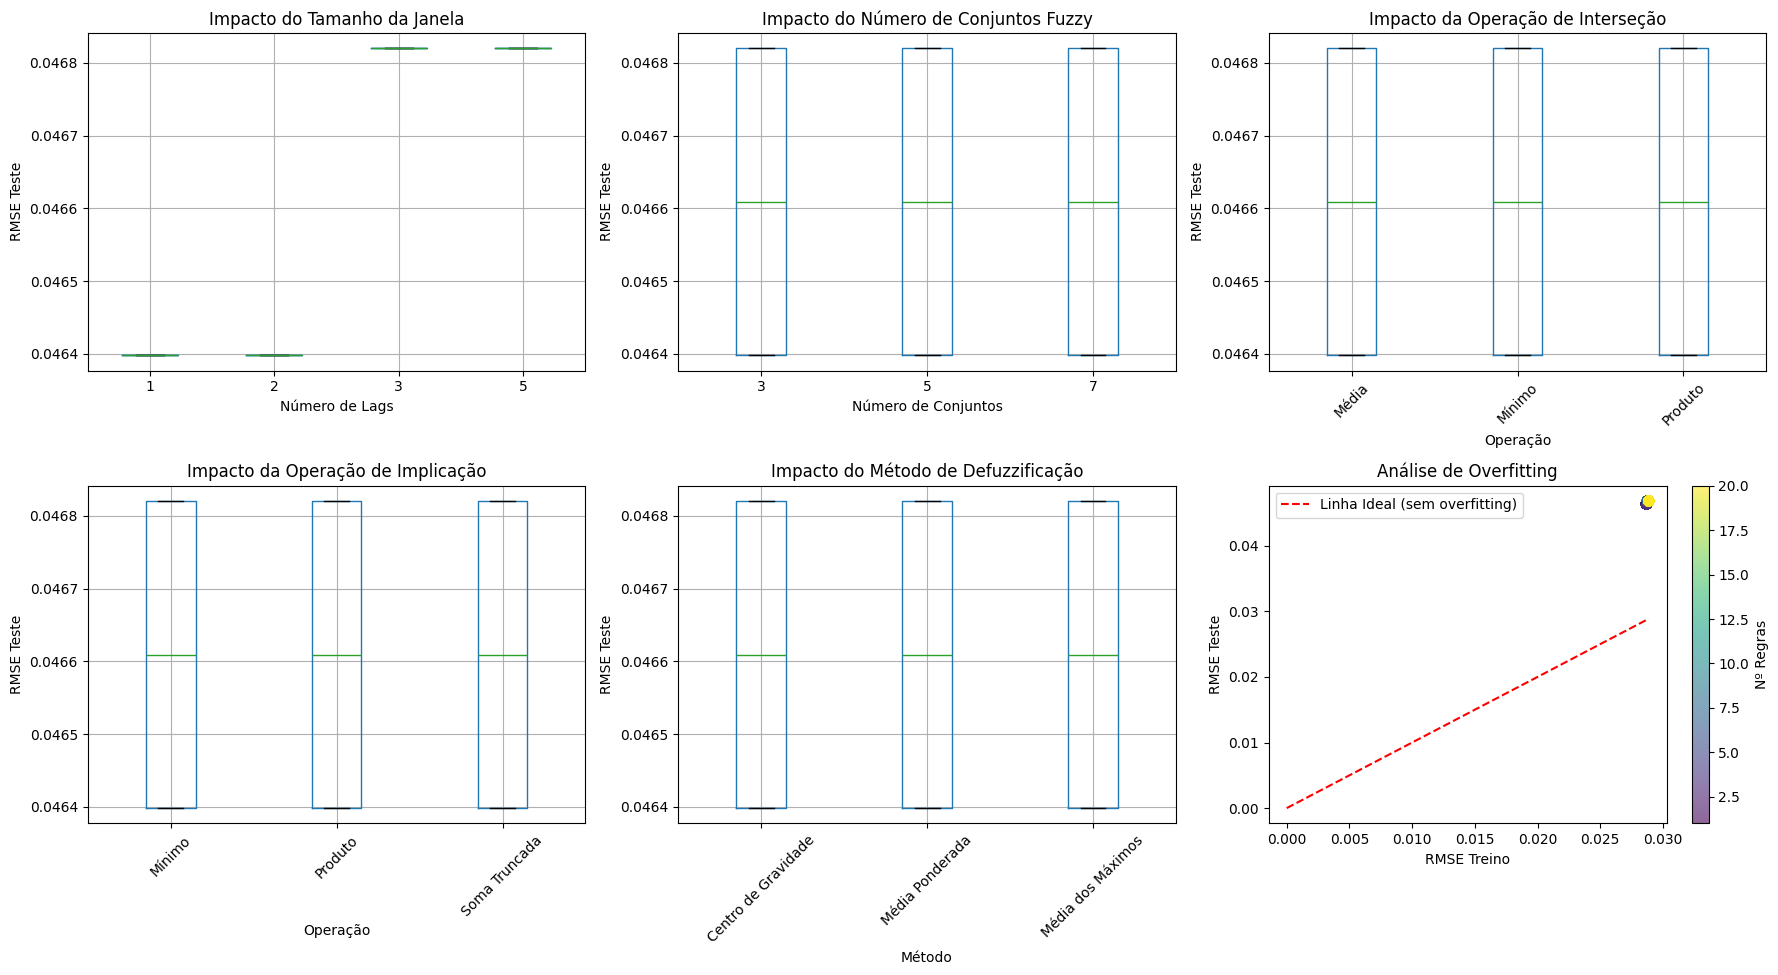

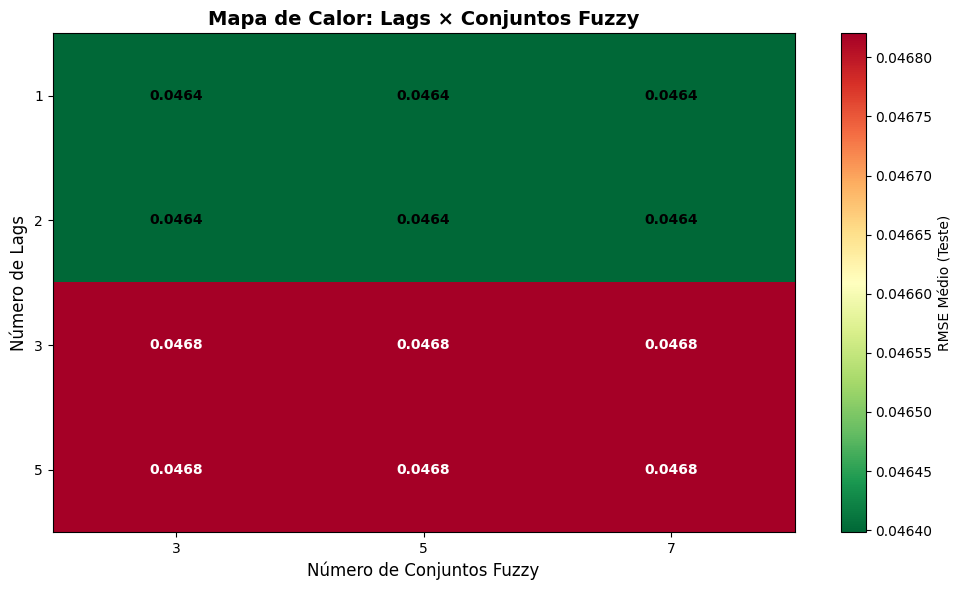

In [13]:

if len(df_resultados) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Análise de Sensibilidade dos Hiperparâmetros', fontsize=16, fontweight='bold')
    
    ax = axes[0, 0]
    df_resultados.boxplot(column='RMSE_Teste', by='Lags', ax=ax)
    ax.set_title('Impacto do Tamanho da Janela')
    ax.set_xlabel('Número de Lags')
    ax.set_ylabel('RMSE Teste')
    ax.get_figure().suptitle('') 

    ax = axes[0, 1]
    df_resultados.boxplot(column='RMSE_Teste', by='Conjuntos', ax=ax)
    ax.set_title('Impacto do Número de Conjuntos Fuzzy')
    ax.set_xlabel('Número de Conjuntos')
    ax.set_ylabel('RMSE Teste')
    ax.get_figure().suptitle('')

    ax = axes[0, 2]
    df_resultados.boxplot(column='RMSE_Teste', by='Interseção', ax=ax)
    ax.set_title('Impacto da Operação de Interseção')
    ax.set_xlabel('Operação')
    ax.set_ylabel('RMSE Teste')
    ax.tick_params(axis='x', rotation=45)
    ax.get_figure().suptitle('')

    ax = axes[1, 0]
    df_resultados.boxplot(column='RMSE_Teste', by='Implicação', ax=ax)
    ax.set_title('Impacto da Operação de Implicação')
    ax.set_xlabel('Operação')
    ax.set_ylabel('RMSE Teste')
    ax.tick_params(axis='x', rotation=45)
    ax.get_figure().suptitle('')
    

    ax = axes[1, 1]
    df_resultados.boxplot(column='RMSE_Teste', by='Defuzzificação', ax=ax)
    ax.set_title('Impacto do Método de Defuzzificação')
    ax.set_xlabel('Método')
    ax.set_ylabel('RMSE Teste')
    ax.tick_params(axis='x', rotation=45)
    ax.get_figure().suptitle('')
    
    ax = axes[1, 2]
    scatter = ax.scatter(df_resultados['RMSE_Treino'], df_resultados['RMSE_Teste'], 
                        c=df_resultados['Regras'], cmap='viridis', alpha=0.6, s=50)
    ax.plot([0, df_resultados['RMSE_Treino'].max()], 
            [0, df_resultados['RMSE_Treino'].max()], 
            'r--', label='Linha Ideal (sem overfitting)')
    ax.set_title('Análise de Overfitting')
    ax.set_xlabel('RMSE Treino')
    ax.set_ylabel('RMSE Teste')
    ax.legend()
    plt.colorbar(scatter, ax=ax, label='Nº Regras')
    
    plt.tight_layout()
    plt.show()


    pivot_rmse = df_resultados.pivot_table(
        values='RMSE_Teste', 
        index='Lags', 
        columns='Conjuntos', 
        aggfunc='mean'
    )
    
    plt.figure(figsize=(10, 6))
    plt.imshow(pivot_rmse.values, cmap='RdYlGn_r', aspect='auto')
    plt.colorbar(label='RMSE Médio (Teste)')
    plt.title('Mapa de Calor: Lags × Conjuntos Fuzzy', fontsize=14, fontweight='bold')
    plt.xlabel('Número de Conjuntos Fuzzy', fontsize=12)
    plt.ylabel('Número de Lags', fontsize=12)
    plt.xticks(range(len(pivot_rmse.columns)), pivot_rmse.columns)
    plt.yticks(range(len(pivot_rmse.index)), pivot_rmse.index)
    
    for i in range(len(pivot_rmse.index)):
        for j in range(len(pivot_rmse.columns)):
            value = pivot_rmse.iloc[i, j]
            if not np.isnan(value):
                plt.text(j, i, f'{value:.4f}', 
                        ha='center', va='center', 
                        color='white' if value > pivot_rmse.values.mean() else 'black',
                        fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Não há dados para visualizar.")

1. Gráfico: Impacto do Tamanho da Janela (Lags)
O que ele mostra: O erro médio (RMSE) para janelas de 1, 2, 3 e 5 dias.

    - "Observa-se que o aumento da janela temporal não resultou em ganho de desempenho. Pelo contrário, janelas superiores a 2 dias apresentaram degradação do RMSE, sugerindo que a série possui forte dependência Markoviana de primeira ou segunda ordem."

2. Gráfico: Impacto do Número de Conjuntos Fuzzy
O que ele mostra: O erro médio ao usar 3, 5 ou 7 conjuntos fuzzy (granularidade).

-  Aumentar a complexidade do modelo (de 3 para 7 conjuntos) não trouxe benefício nenhum. Geralmente, esperamos que mais conjuntos dêem mais precisão, mas aqui, 3 conjuntos (Baixo, Médio, Alto) já foram suficientes para capturar toda a dinâmica que o modelo conseguia enxergar. Usar 7 conjuntos apenas aumentou o custo computacional e o número de regras, sem baixar o erro.

A análise de granularidade revelou um platô de desempenho. O uso de 3 conjuntos fuzzy apresentou o mesmo erro médio que configurações mais complexas (5 ou 7). Seguindo o princípio da parcimônia (Navalha de Ockham), a configuração com 3 conjuntos é preferível por ser mais simples e interpretável.